
<a id='career'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Pesquisa de Emprego IV: Modelando a Escolha da Carreira


<a id='index-0'></a>

## Contéudo

- [Pesquisa de Emprego IV: Modelando a Escolha da Carreira](#Pesquisa-de-Emprego-IV:-Modelando-a-Escolha-da-Carreira)  
  - [Resumo](#Resumo)  
  - [O Modelo](#O-Modelo)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

A seguir, estudaremos um problema computacional referente a opções de carreira e emprego.

O modelo é originalmente devido a Derek Neal [[Nea99]](https://julia.quantecon.org/../zreferences.html#neal1999).

Esta exposição baseia-se na apresentação em [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), seção 6.5.

### Recursos do Modelo

- Carreira e emprego dentro da carreira, ambos são escolhidos para maximizar o fluxo salarial com desconto esperado.  
- Programação dinâmica de horizonte infinito com duas variáveis de estado.

### Recursos

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics

## O Modelo

A seguir, distinguimos entre carreira e emprego, onde:

- uma *carreira* é entendida como um campo geral que abrange muitos empregos possíveis, e
- uma *emprego* é entendido como uma posição em uma empresa em particular.


Para os trabalhadores, os salários podem ser decompostos na contribuição do trabalho e da carreira.

- $ w_t = \theta_t + \epsilon_t $, onde:
  
  - $ \theta_t $ é a contribuição da carreira no momento $ t $.  
  - $ \epsilon_t $ é a contribuição do trabalho no momento $ t $.  
  


No início do momento $ t $, um trabalhador tem as seguintes opções:

- reter um par atual (carreira, emprego) $ (\theta_t, \epsilon_t) $
  — doravante referido como "ficar parado".  
- reter uma carreita atual $ \theta_t $ mas reextrair um trabalho $ \epsilon_t $
  — doravante denominado "novo emprego".
- reextrair ambos uma carreira $ \theta_t $ e um emprego $ \epsilon_t $
  — a seguir denominada de "nova vida".  


As extrações $ \theta $ e $ \epsilon $ são independentes entre si e dos valores passados com:

- $ \theta_t \sim F $  
- $ \epsilon_t \sim G $  


Observe que o trabalhador não tem a opção de manter um emprego, mas redesenhar uma carreira - iniciar uma nova carreira sempre exige iniciar um novo trabalho.

Um jovem trabalhador visa maximizar a soma esperada de salários descontados.


<a id='equation-exw'></a>
$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t w_t \tag{1}
$$

sujeito às restrições de escolha especificadas acima.

Se $ V(\theta, \epsilon) $ denota a função de valor, que é o máximo de [(1)](#equation-exw) sobre todas as políticas possíveis (carreira, emprego), dado o estado inicial $ (\theta, \epsilon) $.

A função de valor obedece:

$$
V(\theta, \epsilon) = \max\{I, II, III\},
$$

onde:


<a id='equation-eyes'></a>
$$
\begin{aligned}
& I = \theta + \epsilon + \beta V(\theta, \epsilon) \\
& II = \theta + \int \epsilon' G(d \epsilon') + \beta \int V(\theta, \epsilon') G(d \epsilon') \nonumber \\
& III = \int \theta' F(d \theta') + \int \epsilon' G(d \epsilon') + \beta \int \int V(\theta', \epsilon') G(d \epsilon') F(d \theta') \nonumber
\end{aligned} \tag{2}
$$

Evidentemente $ I $, $ II $ e $ III $ correspondem a “ficar parado”, “novo emprego” e “nova vida”, respectivamente. 

### Parametrização

Como em [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), seção 6.5, iremos focar numa versão discreta do modelo, parametrizado da seguinte maneira:

- Ambos $ \theta $ e $ \epsilon $ pegam valores no conjunto `linspace(0, B, N)` — um grid uniforme de $ N $ pontos entre $ 0 $ e $ B $ inclusivo  
- $ N = 50 $  
- $ B = 5 $  
- $ \beta = 0.95 $  


As distribuições $ F $ e $ G $ são distribuições discretas
gerando extrações a partir dos pontos do grid `linspace(0, B, N)`.

Uma família muito útil de distribuições discretas é a família beta-binomial, com função de massa de probabilidade:

$$
p(k \,|\, n, a, b)
= {n \choose k} \frac{B(k + a, n - k + b)}{B(a, b)},
\qquad k = 0, \ldots, n
$$

Interpretação:

- extrai $ q $ de uma distribuição β com os parâmetros de forma $ (a, b) $.  
- executa $ n $ independentes ensaios binários, cada um com probabilidade de sucesso $ q $.  
- $ p(k \,|\, n, a, b) $ é a probabilidade de $ k $ sucessos nesses $ n $ ensaios. 


Própriedades agradáveis:

- classe de distribuições muito flexível, incluindo uniforme, simétrico unimodal etc.
- apenas três parâmetros. 


Aqui está uma figura que mostra o efeito de diferentes parâmetros de forma quando  $ n=50 $.


<a id='beta-binom'></a>

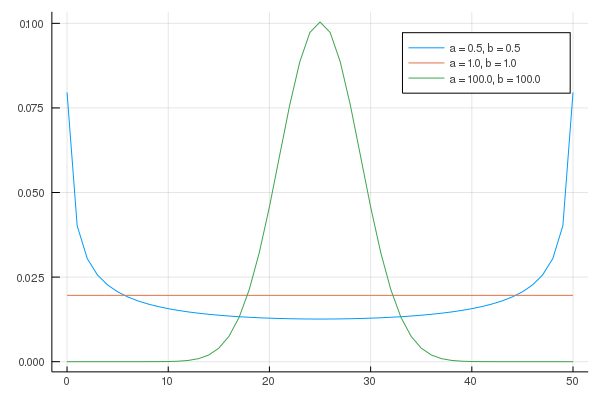

In [3]:
using Plots, QuantEcon, Distributions
gr(fmt=:png);

n = 50
a_vals = [0.5, 1, 100]
b_vals = [0.5, 1, 100]

plt = plot()
for (a, b) in zip(a_vals, b_vals)
    ab_label = "a = $a, b = $b"
    dist = BetaBinomial(n, a, b)
    plot!(plt, 0:n, pdf.(dist, support(dist)), label = ab_label)
end
plt

Implementação:

O código para resolver o problema de DP descrito acima é encontrado abaixo: 

In [4]:
function CareerWorkerProblem(;β = 0.95,
                             B = 5.0,
                             N = 50,
                             F_a = 1.0,
                             F_b = 1.0,
                             G_a = 1.0,
                             G_b = 1.0)
    θ = range(0, B, length = N)
    ϵ = copy(θ)
    dist_F = BetaBinomial(N-1, F_a, F_b)
    dist_G = BetaBinomial(N-1, G_a, G_b)
    F_probs = pdf.(dist_F, support(dist_F))
    G_probs = pdf.(dist_G, support(dist_G))
    F_mean = sum(θ .* F_probs)
    G_mean = sum(ϵ .* G_probs)
    return (β = β, N = N, B = B, θ = θ, ϵ = ϵ,
            F_probs = F_probs, G_probs = G_probs,
            F_mean = F_mean, G_mean = G_mean)
end

function update_bellman!(cp, v, out; ret_policy = false)

    # nova vida. Esta é uma função dos parâmetros de distribuição e é 
    # sempre constante. Não há necessidade de recalculá-lo no loop 
    v3 = (cp.G_mean + cp.F_mean .+ cp.β .*
          cp.F_probs' * v * cp.G_probs)[1] # não necessita de uma matriz de 1 elemento

    for j in 1:cp.N
        for i in 1:cp.N
            # ficar parado
            v1 = cp.θ[i] + cp.ϵ[j] + cp.β * v[i, j]

            # novo emprego
            v2 = (cp.θ[i] .+ cp.G_mean .+ cp.β .*
                  v[i, :]' * cp.G_probs)[1] # não necessita de uma matriz de um único elemento

            if ret_policy
                if v1 > max(v2, v3)
                    action = 1
                elseif v2 > max(v1, v3)
                    action = 2
                else
                    action = 3
                end
                out[i, j] = action
            else
                out[i, j] = max(v1, v2, v3)
            end
        end
    end
end


function update_bellman(cp, v; ret_policy = false)
    out = similar(v)
    update_bellman!(cp, v, out, ret_policy = ret_policy)
    return out
end

function get_greedy!(cp, v, out)
    update_bellman!(cp, v, out, ret_policy = true)
end

function get_greedy(cp, v)
    update_bellman(cp, v, ret_policy = true)
end

get_greedy (generic function with 1 method)

O código define:

- uma tupla nomeada `CareerWorkerProblem` que:
  
  - encapsula todos os detalhes de uma parametrização específica.
  - implementa o operador de Bellman $ T $.
  


Nesse modelo, $ T $ é definido por $ Tv(\theta, \epsilon) = \max\{I, II, III\} $, onde
$ I $, $ II $ e $ III $ são como dados em [(2)](#equation-eyes), substituindo $ V $ com $ v $.

A distribuição de probabilidade padrão `CareerWorkerProblem` corresponde a uma distribuição uniforme discreta (veja [a figura Beta-binomial](#beta-binom)).

De fato, todas as nossas configurações padrão correspondem à versão estudada em [[LS18]](https://julia.quantecon.org/../zreferences.html#ljungqvist2012), seção 6.5.

Portanto, podemos reproduzir as figuras 6.5.1 e 6.5.2 mostradas aqui, que exibem a função de valor e a política ótima, respectivamente.

Aqui está a função de valor:

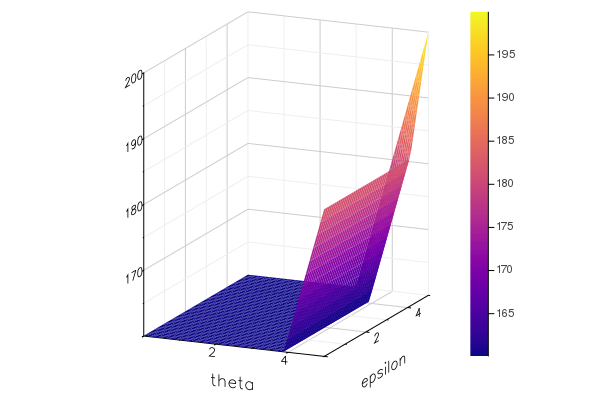

In [5]:
wp = CareerWorkerProblem()
v_init = fill(100.0, wp.N, wp.N)
func(x) = update_bellman(wp, x)
v = compute_fixed_point(func, v_init, max_iter = 500, verbose = false)

plot(linetype = :surface, wp.θ, wp.ϵ, transpose(v), xlabel="theta", ylabel="epsilon",
     seriescolor=:plasma, gridalpha = 1)

A política ótima pode ser representada como a seguinte (veja [Exercício 3](#career-ex3) para obter o código).


<a id='career-opt-pol'></a>

<img src="https://julia.quantecon.org/dynamic_programming/_static/figures/career_solutions_ex3_jl.png" style="width:70%;">

  
Interpretação:

- Se o trabalho e a carreira são ruins ou medíocres, o trabalhador experimentará um novo emprego e uma nova carreira.
- Se a carreira for suficientemente boa, o trabalhador a manterá e experimentará novos empregos até encontrar um emprego suficientemente bom.  
- Se tanto o trabalho quanto a carreira são bons, o trabalhador fica parado. 


Observe que o trabalhador sempre manterá uma carreira suficientemente boa, mas não necessariamente manterá o emprego mais bem remunerado.

O motivo é que altos salários vitalícios exigem que ambas as variáveis sejam grandes e o trabalhador não pode mudar de carreira sem mudar de emprego.

- Às vezes, um bom trabalho deve ser sacrificado para mudar para uma carreira melhor.  

## Exercícios

<a id='career-ex1'></a>

### Exercício 1

Utilizando a parametrização padrão em `CareerWorkerProblem`,
gere e plote caminhos de amostra típicos para  $ \theta $ e $ \epsilon $
quando o trabalhador segue a política ideal.

Em particular, a aleatoriedade do módulo, reproduz a figura a seguir (onde o eixo horizontal representa o tempo).

<img src="https://julia.quantecon.org/dynamic_programming/_static/figures/career_solutions_ex1_jl.png" style="width:70%;">

  
Dica: Para gerar as extrações das distribuições $ F $ e $ G $, use o tipo [DiscreteRV](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/discrete_rv.jl).


<a id='career-ex2'></a>

### Exercício 2

Vamos agora considerar quanto tempo leva para o trabalhador se estabelecer em um emprego permanente, dado um ponto de partida de $ (\theta, \epsilon) = (0, 0) $.

Em outras palavras, queremos estudar a distribuição de uma variável aleatória:

$$
T^* := \text{o primeiro ponto no momento a partir do qual o emprego do trabalhador não muda mais}
$$

Evidentemente, o emprego do trabalhador torna-se permanente se e somente se $ (\theta_t, \epsilon_t) $ entra na região "permanecer parado" do espaço $ (\theta, \epsilon) $.

Se $ S $ denota essa região, $ T^* $ pode ser expresso como o primeiro tempo de passagem para $ S $ sob a política ótima:

$$
T^* := \inf\{t \geq 0 \,|\, (\theta_t, \epsilon_t) \in S\}
$$

Colete 25,000 extrações dessa variável aleatória e compute a mediana (que deve ser mais ou menos 7).

Repita o exercício com $ \beta=0.99 $ e interprete a mudança.


<a id='career-ex3'></a>

### Exercíco 3

Da melhor maneira possível, reproduza [a figura mostrando política ótima](#career-opt-pol).

Dica: O método `get_greedy()` retorna uma representação da política ideal em que os valores 1, 2 e 3 correspondem a "permanecer parado", "novo emprego" e "nova vida", respectivamente. Use esta e as funções de plotagem (por exemplo `contour, contour!`) para reproduzir diferentes sobreamentos.

Agora defina `G_a = G_b = 100` e gere uma nova figura com esses parâmetros. Interprete.

## Soluções

### Exercício 1

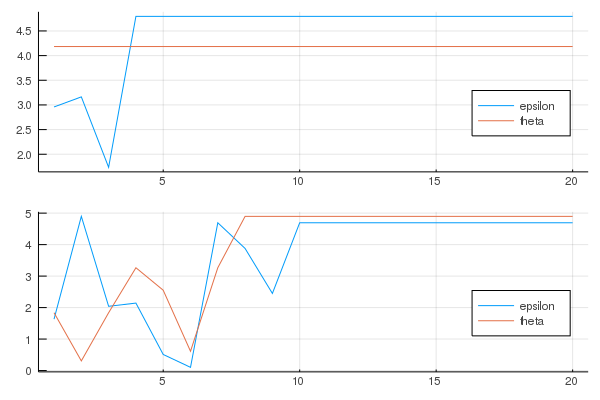

In [6]:
wp = CareerWorkerProblem()

function solve_wp(wp)
    v_init = fill(100.0, wp.N, wp.N)
    func(x) = update_bellman(wp, x)
    v = compute_fixed_point(func, v_init, max_iter = 500, verbose = false)
    optimal_policy = get_greedy(wp, v)
    return v, optimal_policy
end

v, optimal_policy = solve_wp(wp)

F = DiscreteRV(wp.F_probs)
G = DiscreteRV(wp.G_probs)

function gen_path(T = 20)
    i = j = 1
    θ_ind = Int[]
    ϵ_ind = Int[]

    for t=1:T
        # fazer nada se ficar parado
        if optimal_policy[i, j] == 2 # novo emprego
            j = rand(G)[1]
        elseif optimal_policy[i, j] == 3 # nova vida
            i, j = rand(F)[1], rand(G)[1]
        end
        push!(θ_ind, i)
        push!(ϵ_ind, j)
    end
    return wp.θ[θ_ind], wp.ϵ[ϵ_ind]
end

plot_array = Any[]
for i in 1:2
    θ_path, ϵ_path = gen_path()
    plt = plot(ϵ_path, label="epsilon")
    plot!(plt, θ_path, label="theta")
    plot!(plt, legend=:bottomright)
    push!(plot_array, plt)
end
plot(plot_array..., layout = (2,1))

### Exercício 2

A mediana da parametrização original pode ser calculada da seguinte forma:

In [7]:
function gen_first_passage_time(optimal_policy)
    t = 0
    i = j = 1
    while true
        if optimal_policy[i, j] == 1 # ficar parado
            return t
        elseif optimal_policy[i, j] == 2 # Novo emprego
            j = rand(G)[1]
            else # Nova vida
            i, j = rand(F)[1], rand(G)[1]
        end
        t += 1
    end
end


M = 25000
samples = zeros(M)
for i in 1:M
    samples[i] = gen_first_passage_time(optimal_policy)
end
print(median(samples))

7.0

Para computar a mediana com $ \beta=0.99 $ em vez do valor padrão $ \beta=0.95 $, substitua `wp=CareerWorkerProblem()` com `wp=CareerWorkerProblem(β=0.99)`.

As medianas estão sujeitas a aleatoriedade, mas devem ser cerca de 7 e 14, respectivamente. Não é de surpreender que mais trabalhadores pacientes esperem mais para se estabelecerem em seu trabalho final.

In [8]:
wp2 = CareerWorkerProblem(β=0.99)

v2, optimal_policy2 = solve_wp(wp2)

samples2 = zeros(M)
for i in 1:M
    samples2[i] = gen_first_passage_time(optimal_policy2)
end
print(median(samples2))

14.0

### Exercício 3

Aqui está o código para reproduzir a figura original:

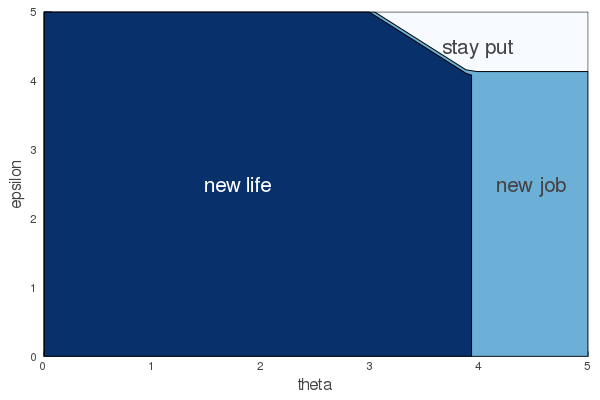

In [9]:
wp = CareerWorkerProblem();
v, optimal_policy = solve_wp(wp)

lvls = [0.5, 1.5, 2.5, 3.5]
x_grid = range(0, 5, length = 50)
y_grid = range(0, 5, length = 50)

contour(x_grid, y_grid, optimal_policy', fill=true, levels=lvls,color = :Blues,
        fillalpha=1, cbar = false)
contour!(xlabel="theta", ylabel="epsilon")
annotate!([(1.8,2.5, text("new life", 14, :white, :center))])
annotate!([(4.5,2.5, text("new job", 14, :center))])
annotate!([(4.0,4.5, text("stay put", 14, :center))])

Agora, precisamos trocar apenas pelos novos parâmetros:

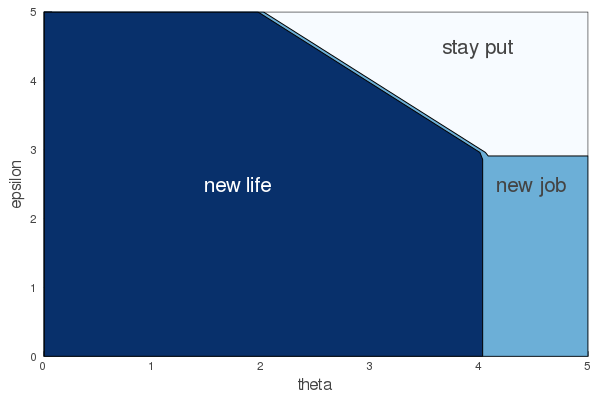

In [10]:
wp = CareerWorkerProblem(G_a=100.0, G_b=100.0); # use novos parâmetros
v, optimal_policy = solve_wp(wp)

lvls = [0.5, 1.5, 2.5, 3.5]
x_grid = range(0, 5, length = 50)
y_grid = range(0, 5, length = 50)

contour(x_grid, y_grid, optimal_policy', fill=true, levels=lvls,color = :Blues,
        fillalpha=1, cbar = false)
contour!(xlabel="theta", ylabel="epsilon")
annotate!([(1.8,2.5, text("new life", 14, :white, :center))])
annotate!([(4.5,2.5, text("new job", 14, :center))])
annotate!([(4.0,4.5, text("stay put", 14, :center))])

Você verá que a região para a qual o trabalhador ficará parado cresceu porque a distribuição para $ \epsilon $
tornou-se mais concentrada em torno da média, tornando os trabalhos com altos salários menos realistas.